In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import segmentation_models as sm
import functools as ft
import pandas as pd
import numpy as np
import tensorflow.keras as keras

sm.set_framework("tf.keras")
sm.framework()

tf.random.set_seed(1024)
SEED = 1024


Segmentation Models: using `keras` framework.


In [ ]:
network = keras.applications.EfficientNetB0()

keras.utils.plot_model(network)

In [5]:
def get_image_decode(image, label):
    image = tf.io.read_file(image, "image")
    label = tf.io.read_file(label, "label")

    image = tf.image.decode_image(image)
    label = tf.image.decode_image(label)

    return image, label


# [w, h, c], 448, 448, 3
def decode_crop(image, label):
    image = image[368 // 2 : -(368 // 2), 256 // 2 : -(256 // 2)]
    label = label[368 // 2 : -(368 // 2), 256 // 2 : -(256 // 2)]

    img_array = []
    label_array = []

    for index in range(4 * 8):
        x, y = index // 8, index % 8
        img_array.append(image[448 * x : 448 * (1 + x), 448 * y : 448 * (1 + y)])
        label_array.append(label[448 * x : 448 * (1 + x), 448 * y : 448 * (1 + y)])

    return tf.data.Dataset.from_tensor_slices((img_array, label_array))


def get_mask(image, label):
    labels = []
    labels.append((label[:, :, 0] == 0) & (label[:, :, 1] == 0) & (label[:, :, 2] == 0))
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 0) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 64) & (label[:, :, 2] == 128)
    )
    labels.append(
        (label[:, :, 0] == 0) & (label[:, :, 1] == 128) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 128) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 64) & (label[:, :, 1] == 0) & (label[:, :, 2] == 128)
    )
    labels.append(
        (label[:, :, 0] == 192) & (label[:, :, 1] == 0) & (label[:, :, 2] == 192)
    )
    labels.append(
        (label[:, :, 0] == 64) & (label[:, :, 1] == 64) & (label[:, :, 2] == 0)
    )
    labels = tf.cast(labels, tf.float32)
    image = tf.cast(image, tf.float32)

    # must perform this
    return image, tf.transpose(labels, [1, 2, 0])


def create_ds(batch_size, istrain=True, maximage=False):
    AUTOTUNE = tf.data.AUTOTUNE

    if istrain:
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_train/**/Images/*.png"
        images = glob.glob(directory, recursive=True)
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_train/**/Labels/*.png"
        labels = glob.glob(directory, recursive=True)
    else:
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_val/**/Images/*.png"
        images = glob.glob(directory, recursive=True)
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_val/**/Labels/*.png"
        labels = glob.glob(directory, recursive=True)

    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ds = ds.cache()
    if istrain:
        ds = ds.shuffle(6400, SEED, reshuffle_each_iteration=True)
    ds = ds.map(get_image_decode, AUTOTUNE)

    if not maximage:
        ds = ds.flat_map(decode_crop)

    ds = ds.map(get_mask, AUTOTUNE)

    # batch and prefetch
    ds = ds.batch(batch_size)

    if istrain:
        ds = ds.prefetch(AUTOTUNE)

    return ds


# Testing starts below


In [6]:
testds = create_ds(1, False)


2022-09-13 21:57:45.293595: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-13 21:57:45.293630: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2022-09-13 21:57:45.294122: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-09-13 22:00:28.778194: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


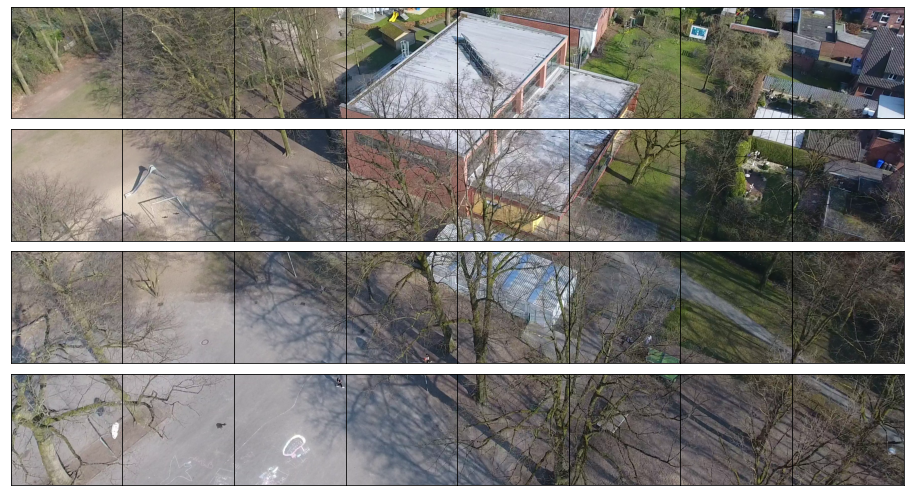

In [8]:
fig, axes = plt.subplots(4, 8, figsize=(16, 9))

# 0 to certain number
which_picture = 1

for idx, (x, y) in testds.skip(which_picture * 32).take(32).enumerate():
    idx_y, idx_x = idx // 8, idx % 8

    # remove ticks
    axes[idx_y][idx_x].set_xticks([])
    axes[idx_y][idx_x].set_yticks([])

    # show picture
    axes[idx_y][idx_x].imshow(x[0] / 255)
    
# remove gap between subplots
fig.subplots_adjust(wspace=0, hspace=0)

2022-09-13 21:57:47.771658: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


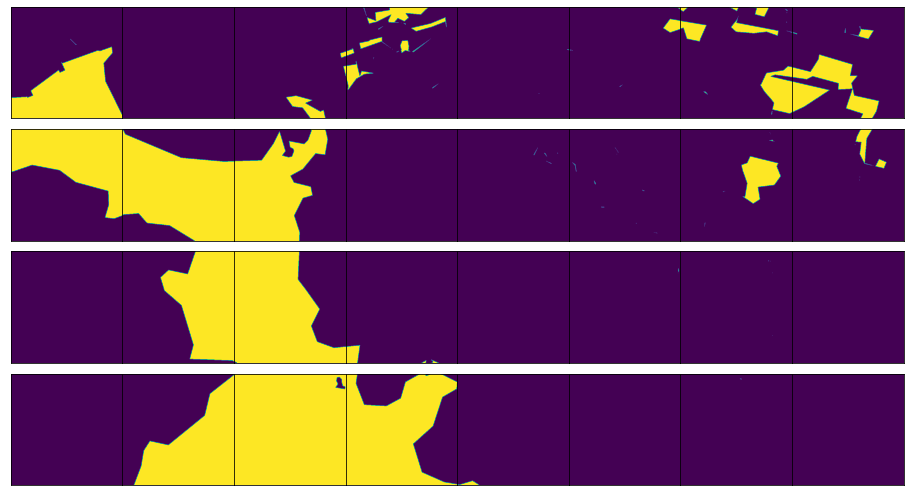

In [7]:
fig, axes = plt.subplots(4, 8, figsize=(16, 9))

# 0 to certain number
which_picture = 1

# channel 0 to 7
channel = 0

for idx, (x, y) in testds.skip(which_picture * 32).take(32).enumerate():
    idx_y, idx_x = idx // 8, idx % 8

    # remove ticks
    axes[idx_y][idx_x].set_xticks([])
    axes[idx_y][idx_x].set_yticks([])

    # show picture
    axes[idx_y][idx_x].imshow(y[0, ..., channel] / 255)
    
# remove gap between subplots
fig.subplots_adjust(wspace=0, hspace=0)